# Exploring photon heights with ICESat-2 (ATL03)

Information obtained primarily from the ATL03 Algorithm Theoretical Basis Document (ATBD, Neumann et al., 2019) and the NSIDC product description page: https://nsidc.org/data/atl03.   

* Notebook author: Ellen Buckley, heavily based on 2019 Hackweek notebook by Alek Petty, and relying extensively on the ATBD and product description.   
* Description: Notebook describing the ICESat-2 ATL03 product.   
* Input requirements: Any example ATL03 data file.   
* Date: June 2020
* More info: See the ATL03 Algorithm Theoretical Basis Document (ATBD): https://icesat-2.gsfc.nasa.gov/sites/default/files/page_files/ICESat2_ATL03_ATBD_r001.pdf and the known issues document: https://nsidc.org/sites/nsidc.org/files/technical-references/ATL03_Known_Issues_May2019.pdf

## Notebook objectives
* General understanding of the data included in a typical ATL03 file.
* Reading in, plotting and basic analysis of ATL03 data.
* What we can learn from ATL03 to derive the ATL07 surface height segments


In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import h5py  
#import s3fs
from astropy.time import Time

## Select and Import Data

#### Granule Selection

ATL03 data are separated into granules that make up 1/14th of an orbit, so there are 14 regions. The Arctic regions are 03, 04, and 05.

region 03: 59.5° N → 80° N (ascending)

region 04: 80° N (ascending) → 80° N (descending)

region 05: 80° N → 59.5° N (descending)

Image showing ATL03 polar regions: credit Tyler Sutterly, github.com/tsutterley/

![title](ICESat-2_granules_polar.png)

We will work with one granule from region 04 in this notebook, you can either grab it from Amazon S3 (at the hackweek) or download from NSIDC if you are running this on your local machine:

ATL03_20190206123200_06120204_002_01.h5


#### Import Data

In [4]:
fname='ATL03_20190206123200_06120204_002_01.h5'
f = h5py.File(fname, 'r')
#check to see if it is forward (1)  or backward (0) orientation to know which beam is strong/weak
print(f['orbit_info/sc_orient'][0])

0


in backward orientation, left beams are strong, right are weak. Lets choose the gt1l, a strong beam. Now we bring in basic parameters and store into dataframe
* lat_ph: latitude (decimal degrees) of each received photon
* lon_ph: longitude (decimal degrees) of each received photon 
* h_ph:  height of each received photon, relative to the WGS-84 ellipsoid (with some, not all corrections applied, see background info above)
* delta_time: seconds from ATLAS Standard Data Product Epoch. use the epoch parameter to convert to gps time
* signal_conf_ph: confidence associated with each photon, column for each surface type. column [2] for sea ice. confidence level 0: noise 1: buffer 2: low 3: medium 4: high

In [5]:
beam='gt1l'
heights=f[beam+'/heights/h_ph'][:]
lats=f[beam+'/heights/lat_ph'][:]
lons=f[beam+'/heights/lon_ph'][:]
# time is in seconds 
dt=f[beam+'/heights/delta_time'][:]
epoch=f['/ancillary_data/atlas_sdp_gps_epoch'][0]
#time= Time(epoch+dt,format='gps')
conf=f[beam+'/heights/signal_conf_ph'][:,2] #choose column 2 for confidence of sea ice photons


In [6]:
df03=pd.DataFrame({'lats':lats,'lons':lons,'heights':heights,'dt':dt,'conf':conf})
df03.head()

,lats,lons,heights,dt,conf
0,79.990105,-48.420387,1988.997803,3.469152e+07,-1
1,79.990104,-48.420387,1989.362915,3.469152e+07,-1
2,79.990104,-48.420387,1989.231079,3.469152e+07,-1
3,79.990104,-48.420387,1989.333374,3.469152e+07,-1
4,79.990105,-48.420389,1985.447388,3.469152e+07,-1


## Map data

Here we are using cartopy to map the data. Because ATL03 granules contain A LOT of data, we can subset the data and take every 1000th point to get an idea of where the data are and what the variables look like.

#### Map the data to see location

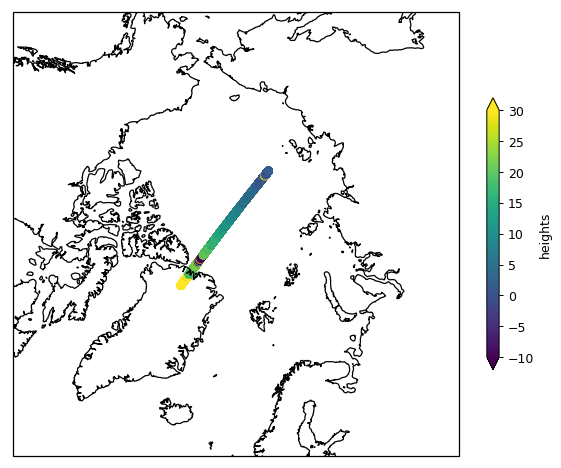

In [7]:
var= 'heights' #choose which variable we want to plot

## we will want to set colorbar parameters based on the chosen variable
vmin=-10
vmax=30
ticks=np.arange(-20,100,5)


plt.figure(figsize=(8,8), dpi= 90)
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0)) # choose polar sterographic for projection
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
plt.scatter(df03['lons'][::1000], df03['lats'][::1000],c=df03[var][::1000], cmap='viridis', vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
plt.colorbar(label=var, shrink=0.5, ticks=ticks,extend='both')

## Plot a closer look at the data

Here we are subsetting the data based on a region of interest. We have to correct the time variable because it is in gps seconds. We also will want to look at alongtrack distance, so we will calculate distance from the first point in our subsetted data. Then we will plot height v. time and height v. alongtrack distance. 

### Closer look at section

In [182]:
lonmin,lonmax,latmin,latmax= [-64,-51,82,83]

In [183]:
## create bounding box of interest:
lonmin,lonmax,latmin,latmax= [-90,-30,86,86.1]

bbox=(df03['lons']>lonmin)&(df03['lons']<lonmax)&(df03['lats']>latmin)&(df03['lats']<latmax)
df_cut=df03[bbox]

## correct time
df_cut['time']=Time(epoch+df_cut['dt'],format='gps').utc.datetime

## calculate along track distance: using vincenty method from geopy.distance
coords_1 = (df_cut.lats.values[0], df_cut.lons.values[0]) #set reference lat,lon
ATdis= lambda a,b: vincenty(coords_1, (a, b)).m #create function to apply to columns of df

df_cut['AT_dist']= df_cut.apply(lambda x: ATdis(x.lats, x.lons), axis=1)

df_cut.head()

,conf,dt,heights,lats,lons,time,AT_dist
7112727,4,3.469162e+07,19.335434,86.000002,-67.839525,2019-02-06 12:33:39.790575,0.000000
7112728,4,3.469162e+07,19.146452,86.000002,-67.839526,2019-02-06 12:33:39.790575,0.002358
7112729,4,3.469162e+07,19.043926,86.000002,-67.839526,2019-02-06 12:33:39.790575,0.003638
7112730,4,3.469162e+07,19.220772,86.000002,-67.839526,2019-02-06 12:33:39.790575,0.001431
7112731,4,3.469162e+07,19.497667,86.000002,-67.839525,2019-02-06 12:33:39.790575,0.002024


Height v. Time plot

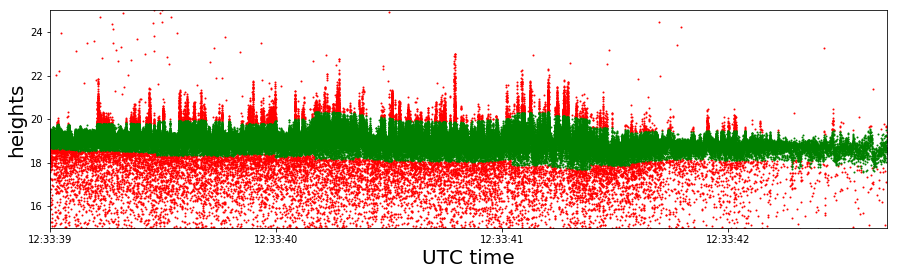

In [151]:
plt.subplots(1,1,figsize=(15,4))
plt.scatter(df_cut.time.values[df_cut.conf==1],df_cut.heights.values[df_cut.conf==1],c='r',s=1)
plt.scatter(df_cut.time.values[df_cut.conf==2],df_cut.heights.values[df_cut.conf==2],c='orange',s=1)
plt.scatter(df_cut.time.values[df_cut.conf==3],df_cut.heights.values[df_cut.conf==3],c='g',s=1)
plt.scatter(df_cut.time.values[df_cut.conf==4],df_cut.heights.values[df_cut.conf==4],c='g',s=1)
plt.xlabel('UTC time',fontsize=20)
plt.ylabel('heights',fontsize=20)
plt.ylim(15,25);
plt.xlim(df_cut.time.values[0],df_cut.time.values[-1]);

Height v. along track distance plot

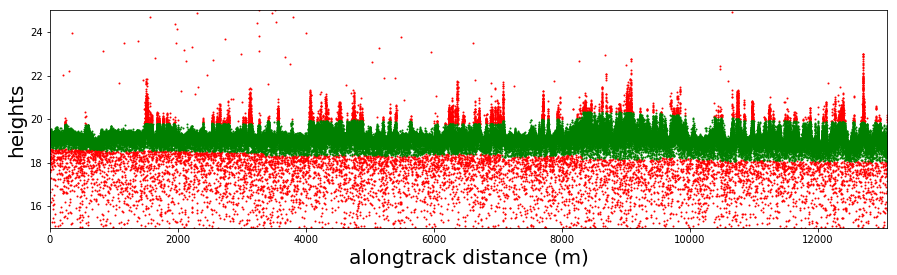

In [156]:
plt.subplots(1,1,figsize=(15,4))
plt.scatter(df_cut.AT_dist.values[df_cut.conf==1],df_cut.heights.values[df_cut.conf==1],c='r',s=1)
plt.scatter(df_cut.AT_dist.values[df_cut.conf==2],df_cut.heights.values[df_cut.conf==2],c='orange',s=1)
plt.scatter(df_cut.AT_dist.values[df_cut.conf==3],df_cut.heights.values[df_cut.conf==3],c='g',s=1)
plt.scatter(df_cut.AT_dist.values[df_cut.conf==4],df_cut.heights.values[df_cut.conf==4],c='g',s=1)
plt.xlabel('alongtrack distance (m)',fontsize=20)
plt.ylabel('heights',fontsize=20)
plt.ylim(15,25);
plt.xlim(df_cut.AT_dist.values[0],df_cut.AT_dist.values[-1]);

Let's look at just 1 km of data

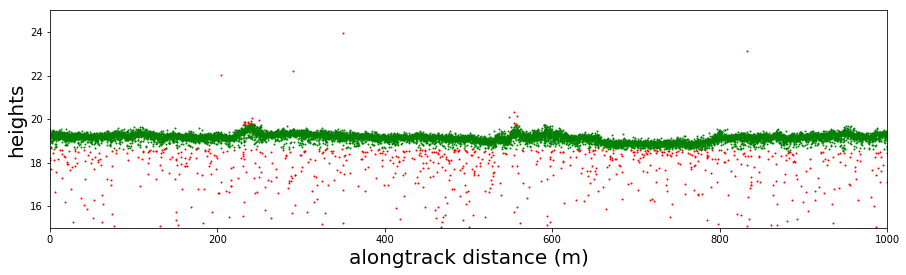

In [157]:
plt.subplots(1,1,figsize=(15,4))
plt.scatter(df_cut.AT_dist.values[df_cut.conf==1],df_cut.heights.values[df_cut.conf==1],c='r',s=1)
plt.scatter(df_cut.AT_dist.values[df_cut.conf==2],df_cut.heights.values[df_cut.conf==2],c='orange',s=1)
plt.scatter(df_cut.AT_dist.values[df_cut.conf==3],df_cut.heights.values[df_cut.conf==3],c='g',s=1)
plt.scatter(df_cut.AT_dist.values[df_cut.conf==4],df_cut.heights.values[df_cut.conf==4],c='g',s=1)
plt.xlabel('alongtrack distance (m)',fontsize=20)
plt.ylabel('heights',fontsize=20)
plt.ylim(15,25);
plt.xlim(df_cut.AT_dist.values[0],1000);

Here we can see the high confidence surface photons in green. The background photons (red) are from subsurface scattering. Note that if we were looking at summer data there would be more background photons above the surface due to the solar background.

### Look at strong beam v. weak beam

In [165]:
# pull in weak beam, combining bounding box, time correction, alongtrack distance calculation.
lonmin,lonmax,latmin,latmax= [-90,-30,86,86.1]

## split up data by photon confidence

beam='gt1r'
heights=f[beam+'/heights/h_ph'][:]
lats=f[beam+'/heights/lat_ph'][:]
lons=f[beam+'/heights/lon_ph'][:]
dt=f[beam+'/heights/delta_time'][:] # time is in seconds 
epoch=f['/ancillary_data/atlas_sdp_gps_epoch'][0]

conf=f[beam+'/heights/signal_conf_ph'][:,2] #choose column 2 for confidence of sea ice photons

bbox=(lons>lonmin)&(lons<lonmax)&(lats>latmin)&(lats<latmax)
df_cut_w=pd.DataFrame({'lats':lats[bbox],'lons':lons[bbox],'heights':heights[bbox],'dt':dt[bbox],'conf':conf[bbox]})
## correct time
df_cut_w['time']=Time(epoch+df_cut_w['dt'],format='gps').utc.datetime

## calculate along track distance: using vincenty method from geopy.distance
coords_1 = (df_cut_w.lats.values[0], df_cut_w.lons.values[0]) #set reference lat,lon

df_cut_w['AT_dist']= df_cut_w.apply(lambda x: ATdis(x.lats, x.lons), axis=1)


df_cut_w.head()


,conf,dt,heights,lats,lons,time,AT_dist
0,4,3.469162e+07,19.301861,86.000002,-67.828278,2019-02-06 12:33:40.130075,0.000000
1,4,3.469162e+07,19.333200,86.000002,-67.828278,2019-02-06 12:33:40.130075,0.000341
2,4,3.469162e+07,19.291342,86.000002,-67.828278,2019-02-06 12:33:40.130075,0.000115
3,4,3.469162e+07,19.254053,86.000002,-67.828278,2019-02-06 12:33:40.130075,0.000520
4,4,3.469162e+07,19.430183,86.000007,-67.828325,2019-02-06 12:33:40.130175,0.709347


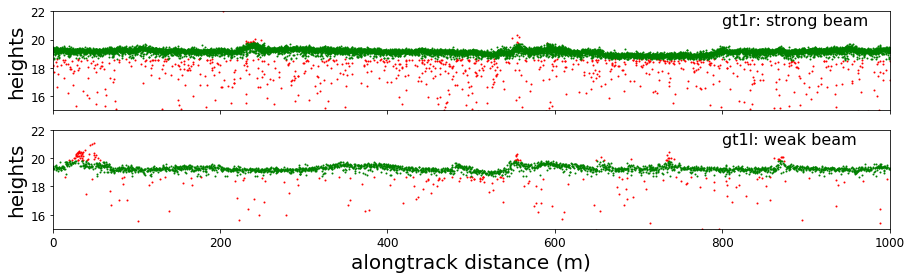

In [177]:
fig,ax=plt.subplots(2,1,figsize=(15,4), sharex=True)

ax[0].scatter(df_cut.AT_dist.values[df_cut.conf==1],df_cut.heights.values[df_cut.conf==1],c='r',s=1)
ax[0].scatter(df_cut.AT_dist.values[df_cut.conf==2],df_cut.heights.values[df_cut.conf==2],c='orange',s=1)
ax[0].scatter(df_cut.AT_dist.values[df_cut.conf==3],df_cut.heights.values[df_cut.conf==3],c='g',s=1)
ax[0].scatter(df_cut.AT_dist.values[df_cut.conf==4],df_cut.heights.values[df_cut.conf==4],c='g',s=1)
ax[0].set_ylabel('heights',fontsize=20)
ax[0].tick_params(labelsize=12)
ax[0].set_ylim(15,22);
ax[0].text(800,21,'gt1r: strong beam',fontsize=16)


ax[1].scatter(df_cut_w.AT_dist.values[df_cut_w.conf==1],df_cut_w.heights.values[df_cut_w.conf==1],c='r',s=1)
ax[1].scatter(df_cut_w.AT_dist.values[df_cut_w.conf==2],df_cut_w.heights.values[df_cut_w.conf==2],c='orange',s=1)
ax[1].scatter(df_cut_w.AT_dist.values[df_cut_w.conf==3],df_cut_w.heights.values[df_cut_w.conf==3],c='g',s=1)
ax[1].scatter(df_cut_w.AT_dist.values[df_cut_w.conf==4],df_cut_w.heights.values[df_cut_w.conf==4],c='g',s=1)
ax[1].set_ylabel('heights',fontsize=20)
ax[1].tick_params(labelsize=12)
ax[1].set_ylim(15,22);
ax[1].text(800,21,'gt1l: weak beam',fontsize=16)

plt.xlabel('alongtrack distance (m)',fontsize=20)
plt.xlim(df_cut.AT_dist.values[0],1000);

Notice fewer returns from the weak beam. The energy ratio between the weak and strong beams is approximately 1:4 and are separated by 90 m in the across-track direction. 